In [1]:
from scripts import bookdatafunctions as bdf
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Constants

#In the deprel column
#Dependency relation types in Finnish UD
DEPRELS = ['root', 'nsubj', 'advmod', 'obl', 'obj', 'conj', 'aux', 'cc', 'amod', 'nmod:poss', 'mark', 'cop', 'nsubj:cop', 'advcl', 'xcomp', 'case', 'det', 'ccomp', 'nmod', 'parataxis', 'acl:relcl', 'acl', 'xcomp:ds', 'discourse', 'nummod', 'fixed', 'cop:own', 'appos', 'flat:name', 'compound:nn', 'aux:pass', 'vocative', 'nmod:gobj', 'nmod:gsubj', 'compound:prt', 'csubj:cop', 'flat:foreign', 'orphan', 'cc:preconj', 'csubj', 'compound', 'flat', 'goeswith']

#In the feats column
#Cases in Finnihs UD
CASES = ['Case=Nom', 'Case=Gen', 'Case=Par', 'Case=Ill', 'Case=Ine', 'Case=Ela', 'Case=Ade', 'Case=All', 'Case=Ess', 'Case=Abl', 'Case=Tra', 'Case=Acc', 'Case=Ins', 'Case=Abe', 'Case=Com']
#Verb forms in Finnish UD
VERBFORMS = ['VerbForm=Fin', 'VerbForm=Inf', 'VerbForm=Part']
#Verb tenses in Finnish UD
VERBTENSES = ['Tense=Pres', 'Tense=Past']
#Verb voices in Finnish UD
VERBVOICES = ['Voice=Act', 'Voice=Pass']
#Verb moods in Finnish UD
VERBMOODS = ['Mood=Ind', 'Mood=Cnd', 'Mood=Imp']
#Verb 'person' in Finnish UD (aka first person, second person and so on)
PERSONS = ['Person=0', 'Person=1', 'Person=2', 'Person=3']
#Verb 'number' in Finnish UD (aka first singluar person [me] or first plural person [we] and so on)
NUMBERS = ['Number=Sing', 'Number=Plur']
#Connegative (aka verb that has been given a negative meaning by 'ei')
CONNEGATIVE = ['Connegative=Yes']
#Degrees in Finnish UD (positive, comparative, and superlative)
DEGREES = ['Degree=Pos','Degree=Cmp','Degree=Sup']
FEATS = CASES + VERBFORMS + VERBTENSES + VERBVOICES + VERBMOODS + PERSONS + NUMBERS + CONNEGATIVE + DEGREES
#In the upos column
#POS tags in Finnish UD
POS = ['NOUN', 'VERB', 'PRON', 'ADV', 'AUX', 'ADJ', 'PROPN', 'CCONJ', 'SCONJ', 'ADP', 'NUM', 'INTJ']


ALL_FEATS = DEPRELS + FEATS + POS 


In [3]:


#Excel-file hosting information to map a book to its 'exact' intended reading age

ISBN2AGE_PATH = "ISBN_MAPS/ISBN2AGE.xlsx"

print("Start...")

#Load the corpus and, clean lemmas (remove Japanese characters, punctuation, etc.), and map books to their intended reading ages

books = bdf.mapGroup2Age(bdf.initBooksFromConllus("Conllus"), ISBN2AGE_PATH)

#Create three sub-corpora. 
# 
# Sub_1 has ages 5,6,7,8
# Sub_2 has ages 9,10,11,12
# Sub_3 has ages 13,14,15

sub_1 = bdf.combineSubCorpDicts([bdf.getRangeSubCorp(books, 6), bdf.getDistinctSubCorp(books, 8)])
sub_2 = bdf.combineSubCorpDicts([bdf.getRangeSubCorp(books, 10), bdf.getDistinctSubCorp(books, 12)])
sub_3 = bdf.getRangeSubCorp(books, 14)

print("Processing dependency relations...")

#Basically map a feature that was listed above (in this case a dependency relation type)
#To the Cohen's D value gotten from analysing this feature between two sub-corpora
#This is where the Key Feature Analysis is done
#How these are calculated are in the functions used located in the 'bookdatafunctions.py' file in the 'Scripts' folder

deprel_effect_sizes_12 = {}
deprel_effect_sizes_13 = {}
deprel_effect_sizes_23 = {}

for deprel in DEPRELS:
    deprel_effect_sizes_12[deprel] = bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_1, deprel, True), bdf.getDeprelFeaturePerBook(sub_2, deprel, True))
    deprel_effect_sizes_13[deprel] = bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_1, deprel, True), bdf.getDeprelFeaturePerBook(sub_3, deprel, True))
    deprel_effect_sizes_23[deprel] = bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_2, deprel, True), bdf.getDeprelFeaturePerBook(sub_3, deprel, True))

deprel_effect_sizes = pd.DataFrame({"1-2":deprel_effect_sizes_12.values(), "2-3":deprel_effect_sizes_23.values(), "1-3":deprel_effect_sizes_13.values()}, index=deprel_effect_sizes_23.keys())

print("Processing cases and verb-forms...")

#Same steps as before, just repeated for more features

feats_effect_sizes_12 = {}
feats_effect_sizes_13 = {}
feats_effect_sizes_23 = {}


for feat in FEATS:
    feats_effect_sizes_12[feat] = bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_1, feat, True), bdf.getFeatsFeaturePerBook(sub_2, feat, True))
    feats_effect_sizes_13[feat] = bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_1, feat, True), bdf.getFeatsFeaturePerBook(sub_3, feat, True))
    feats_effect_sizes_23[feat] = bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_2, feat, True), bdf.getFeatsFeaturePerBook(sub_3, feat, True))

feats_effect_sizes = pd.DataFrame({"1-2":feats_effect_sizes_12.values(), "2-3":feats_effect_sizes_23.values(), "1-3":feats_effect_sizes_13.values()}, index=feats_effect_sizes_23.keys())

print("Processing POS features...")

#Same steps as before, just repeated for POS-tags

pos_effect_sizes_12 = {}
pos_effect_sizes_13 = {}
pos_effect_sizes_23 = {}

for pos in POS:
    pos_effect_sizes_12[pos] = bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_1, pos, True), bdf.getPosFeaturePerBook(sub_2, pos, True))
    pos_effect_sizes_13[pos] = bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_1, pos, True), bdf.getPosFeaturePerBook(sub_3, pos, True))
    pos_effect_sizes_23[pos] = bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_2, pos, True), bdf.getPosFeaturePerBook(sub_3, pos, True))

pos_effect_sizes = pd.DataFrame({"1-2":pos_effect_sizes_12.values(), "2-3":pos_effect_sizes_23.values(), "1-3":pos_effect_sizes_13.values()}, index=pos_effect_sizes_23.keys())

#I also take a look at the Type-Token Ratios of the sub-corpora and include that in the KFA
#Again, how the functions work can be found from the corresponding functions in 'bookdatafunctions.py'

lemma_freqs = bdf.getLemmaFrequencies(books)

word_freqs_1 = bdf.getWordFrequencies(sub_1)
word_freqs_2 = bdf.getWordFrequencies(sub_2)
word_freqs_3 = bdf.getWordFrequencies(sub_3)

word_amounts_1 = bdf.getTokenAmounts(sub_1)
word_amounts_2 = bdf.getTokenAmounts(sub_2)
word_amounts_3 = bdf.getTokenAmounts(sub_3)

print("Processing type-token-ratios...")

ttrs_1 = bdf.getTypeTokenRatios(word_freqs_1, word_amounts_1)
ttrs_2 = bdf.getTypeTokenRatios(word_freqs_2, word_amounts_2)
ttrs_3 = bdf.getTypeTokenRatios(word_freqs_3, word_amounts_3)

ttr_effect_size_12 = bdf.cohensdForSubcorps(ttrs_1.to_dict(), ttrs_2.to_dict())
ttr_effect_size_23 = bdf.cohensdForSubcorps(ttrs_2.to_dict(), ttrs_3.to_dict())
ttr_effect_size_13 = bdf.cohensdForSubcorps(ttrs_1.to_dict(), ttrs_3.to_dict())

ttr_effect_size = pd.DataFrame({"1-2":ttr_effect_size_12, "2-3":ttr_effect_size_23, "1-3":ttr_effect_size_13}, index=['TTR'])

#Combine all the effect sizes into a Pandas Dataframe, so that it is easy to have it all in one place
#This dataframe has features as indexes and names of the sub-coprora compared as the columns (so e.g. "1-2" for the KFA results between sub coprus 1 and sub corpus 2)

effect_sizes = pd.concat([ttr_effect_size, deprel_effect_sizes, feats_effect_sizes, pos_effect_sizes])


f_lemma = bdf.combineFrequencies(lemma_freqs)

Start...
Processing dependency relations...
Processing cases and verb-forms...
Processing POS features...
Processing type-token-ratios...


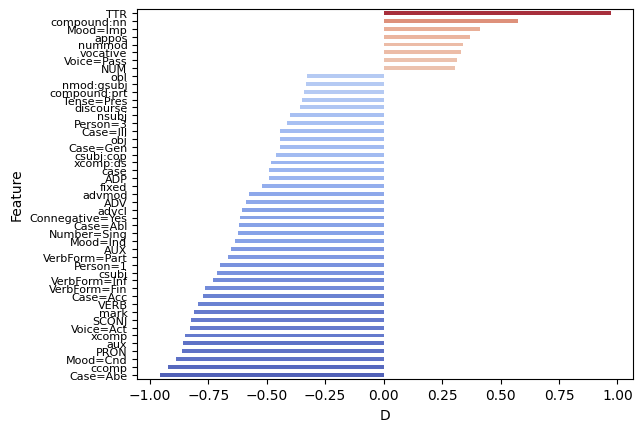

In [4]:
import matplotlib.pyplot as plt
import numpy as np

#Some plotting stuff for visualization. Not cleaned and will change in the future, but it works so it's fine :)
#This is the plot for KFA on subcorpora 1 and 2
#Positive (red) values mean that the feature is more prevalent in sub corpus 1, where as neagitve (blue) values mean its more prevalent in sub corpus 2
plot_12_df = pd.DataFrame({"D":effect_sizes['1-2'].values, "Feature":effect_sizes.index})
plot_12_df = plot_12_df[((plot_12_df['D'] < -0.3) | (plot_12_df['D'] > 0.3))]
plot_12_df = plot_12_df.sort_values(by="D", ascending=False)

def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)


fig, ax = plt.subplots()
ax = sns.barplot(plot_12_df, x="D", y="Feature", legend=False, width=0.5, palette=colors_from_values(plot_12_df['D'].values, "coolwarm"))
ax.tick_params(axis='y', labelsize=8)
plt.setp(ax.patches, linewidth=1)
plt.show()
#g.xticks(data['batch_no'][::50])


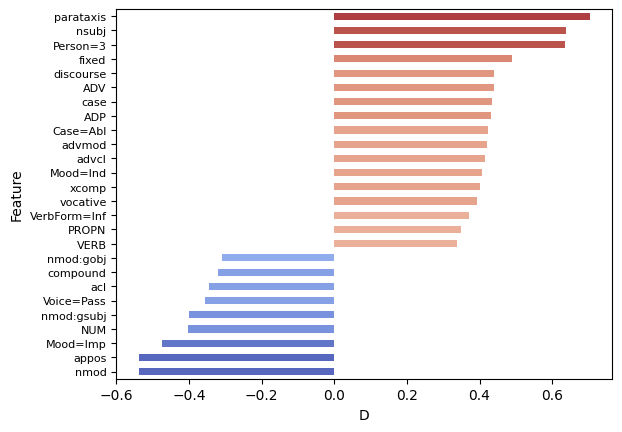

In [5]:
#This is the plot for KFA on subcorpora 2 and 3
plot_23_df = pd.DataFrame({"D":effect_sizes['2-3'].values, "Feature":effect_sizes.index})
plot_23_df = plot_23_df[((plot_23_df['D'] < -0.3) | (plot_23_df['D'] > 0.3))]
plot_23_df = plot_23_df.sort_values(by="D", ascending=False)

fig, ax = plt.subplots()
ax = sns.barplot(plot_23_df, x="D", y="Feature", legend=False, width=0.5, palette=colors_from_values(plot_23_df['D'].values, "coolwarm"))
ax.tick_params(axis='y', labelsize=8)
plt.setp(ax.patches, linewidth=1)
plt.show()


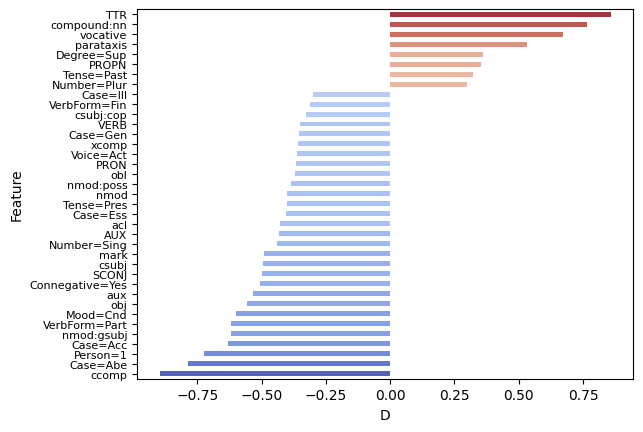

In [6]:
#This is the plot for KFA on subcorpora 1 and 3
plot_13_df = pd.DataFrame({"D":effect_sizes['1-3'].values, "Feature":effect_sizes.index})
plot_13_df = plot_13_df[((plot_13_df['D'] < -0.3) | (plot_13_df['D'] > 0.3))]
plot_13_df = plot_13_df.sort_values(by="D", ascending=False)

fig, ax = plt.subplots()
ax = sns.barplot(plot_13_df, x="D", y="Feature", legend=False, width=0.5, palette=colors_from_values(plot_13_df['D'].values, "coolwarm"))
ax.tick_params(axis='y', labelsize=8)
plt.setp(ax.patches, linewidth=1)
plt.show()
